This Jupyter notebook introduces the concept of using the Chinese Restaurant Process (CRP) and Stochastic Beam Search to represent uncertainty in mixture models. The CRP is a powerful tool for modeling uncertainty over the number of components in a mixture model, while Stochastic Beam Search is an algorithm used for efficient exploration of large search spaces.

In this notebook, we will walk through the steps of implementing the CRP, mixture model, and Stochastic Beam Search algorithm. We will then combine these components to estimate the posterior distribution in a Bayesian setting.


In [84]:

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)


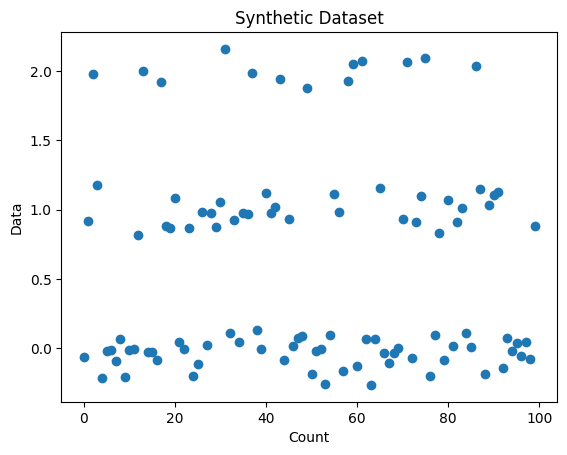

In [195]:
# Generate a synthetic dataset

n_data = 100
# true parameters for the mixture model
true_parameters = [0.5, 0.3, 0.2]
data = []

# Choose a mixture component according to the true parameters, generate data pt from it
for _ in range(n_data):
    component = np.random.choice(len(true_parameters), p=true_parameters)
    data_point = np.random.normal(loc=component, scale=.1)
    data.append(data_point)

plt.scatter(range(n_data), data)
plt.xlabel('Count')
plt.ylabel('Data')
plt.title('Synthetic Dataset')
plt.show()


In [211]:
# Chinese Restaurant Process (CRP)

def chinese_restaurant_process(data, alpha):
    # alpha: concentration parameter

    num_data_points = len(data)
    table_assignments = []
    table_counts = []
    
    # Assign data point to the first table
    table_assignments.append(0)
    table_counts.append(1)
    for i in range(1, num_data_points):
        # Calculate the probability of sitting at an existing table
        prob_existing_table = [count / (i + alpha) for count in table_counts]

        # Calculate the probability of sitting at a new table
        prob_new_table = alpha / (i + alpha)

        probabilities = prob_existing_table + [prob_new_table]

        table_assignment = np.random.choice(len(probabilities), p=probabilities)

        if table_assignment == len(table_counts):
            # Sit at a new table
            table_assignments.append(table_assignment)
            table_counts.append(1)
        else:
            # Sit at an existing table
            table_assignments.append(table_assignment)
            table_counts[table_assignment] += 1

    
    return table_assignments, table_counts



table_assignments, table_counts = chinese_restaurant_process(data, alpha=1)

print("Table Assignments:", table_assignments)
print("Table Counts:", table_counts)


Table Assignments: [0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 0, 0, 4, 2, 0, 1, 2, 3, 2, 0, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 4, 1, 1, 0, 0, 0, 3, 1, 0, 1, 1, 0, 1, 0, 0, 0]
Table Counts: [42, 34, 19, 3, 2]


In [212]:
# Mixture Model

def mixture_model(data, table_assignments, table_counts):
    n_component = len(table_counts)
    
    # Estimate the parameters for each mixture component (table)
    component_parameters = []
    for i in range(n_component):
        # data points assigned to the current component (table)
        component_data = [data[j] for j, table in enumerate(table_assignments) if table == i]
        
        # the parameter for the current component (table)
        if len(component_data) > 0:
            component_parameter = np.mean(component_data)  # Here we use the mean as the parameter estimate
            # TODO
        else:
            component_parameter = 0.0  
        
        component_parameters.append(component_parameter)
    
    return component_parameters


component_parameters = mixture_model(data, table_assignments, table_counts)

for i, parameter in enumerate(component_parameters):
    print(f"Component {i+1} Parameter: {parameter}")


Component 1 Parameter: 0.5820884383652751
Component 2 Parameter: 0.6872335239370966
Component 3 Parameter: 0.42314835399848666
Component 4 Parameter: 0.40134152870234585
Component 5 Parameter: -0.07561108887071777


In [213]:
# Posterior Estimation using MCMC

def calculate_posterior(data, table_assignments, component_parameters, alpha):
    
    num_data_points = len(data)
    
    # Initialize variables for posterior estimation
    posterior_assignments = []
    posterior_parameters = []
    table_counts = [0] * (max(table_assignments) + 1)
    
    num_samples = 1000
    original_table_assignment = table_assignments.copy()

    for _ in range(num_samples):
        for i in range(num_data_points):
            current_table = table_assignments[i]
            table_counts[current_table] -= 1
            
            # Calculate the probability of sitting at each existing table
            prob_existing_table = table_counts.copy()
            prob_existing_table.append(alpha)
            prob_existing_table = np.array(prob_existing_table) / (num_data_points - 1 + alpha)
            
            # Calculate the probability of sitting at a new table
            prob_new_table = alpha / (num_data_points - 1 + alpha)
            probabilities = np.concatenate((prob_existing_table, [prob_new_table]))
            probabilities = np.maximum(probabilities, 0)  # Ensure non-negativity
            probabilities /= np.sum(probabilities)
            #print('=======',probabilities)
            
            # Sample a new table assignment
            new_table_assignment = np.random.choice(len(probabilities), p=probabilities)
            
            if new_table_assignment == len(probabilities) - 1:
                # Sit at a new table
                table_assignments[i] = max(table_assignments) + 1
                table_counts.append(1)
            else:
                # Sit at an existing table
                table_assignments[i] = new_table_assignment
                if new_table_assignment == len(table_counts):
                    table_counts.append(1)
                else:
                    table_counts[new_table_assignment] += 1
            
            # If the new table assignment is the same as the original table assignment, restore the table count
            if new_table_assignment == original_table_assignment[i]:
                table_counts[new_table_assignment] += 1
        
        # Estimate the component parameters based on the new table assignments
        component_parameters = mixture_model(data, table_assignments, table_counts)
        
        # Store the posterior assignments and parameters
        posterior_assignments.append(table_assignments.copy())
        posterior_parameters.append(component_parameters.copy())
    
    return posterior_assignments, posterior_parameters


posterior_assignments, posterior_parameters = calculate_posterior(data, table_assignments, component_parameters, alpha=1)

# Print the first 5 posterior assignments and parameters
for i in range(5):
    print(f"Sample {i+1}: Assignments - {posterior_assignments[i]}, Parameters - {posterior_parameters[i]}")


Sample 1: Assignments - [5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 8, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 7, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 7, 5, 7, 5, 5, 5, 7, 5, 5, 5, 10, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 7, 5, 5, 5, 9, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 7, 5], Parameters - [0.0, 0.0, 0.0, 0.0, 0.0, 0.5561551439811581, 0.7916692849509323, 0.4735729561653727, -0.014900175307832912, 1.0846386971290485, 0.06719892782813496]
Sample 2: Assignments - [5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 7, 5, 9, 5, 5, 11, 5, 5, 9, 5, 5, 5, 5, 5, 7, 5, 11, 7, 5, 5, 5, 5, 7, 5, 5, 7, 7, 5, 5, 7, 12, 5, 10, 5, 7, 7, 7, 5, 6, 5, 5, 5, 5, 5, 5, 5, 7, 7, 9, 7, 5, 7, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 5, 5, 5, 5, 9, 5, 7, 5, 5, 12, 5, 5, 5, 12, 5, 6, 5, 5], Parameters - [0.0, 0.0, 0.0, 0.0, 0.0, 0.5461409526236733, 0.16766899292952106, 0.46275865842784175, 0.0, 1.4155646804016269, 1.018432683858816, 0.978122903573937, 0.76320630838

In [214]:
def log_likelihood(data, assignment, parameters):
    likelihood = 0
    for i, point in enumerate(data):
        # Assume data is generated from a Gaussian distribution with mean = parameter of assigned component
        # And standard deviation = 1 (or any constant)
        component_parameter = parameters[assignment[i]]
        likelihood += -0.5 * ((point - component_parameter) ** 2)
    return likelihood
'''
# Calculate log likelihood for each sample
log_likelihoods = [log_likelihood(data, assignment, parameters) for assignment, parameters in zip(posterior_assignments, posterior_parameters)]

# Get the indices of the samples with highest log likelihood
best_samples_indices = np.argsort(log_likelihoods)[-beam_width:]

# Get the best samples
best_assignments = [posterior_assignments[i] for i in best_samples_indices]
best_parameters = [posterior_parameters[i] for i in best_samples_indices]

print("Best Assignments:", best_assignments)
print("Best Parameters:", best_parameters)
'''

Best Assignments: [[361, 235, 1158, 895, 1219, 148, 1124, 184, 361, 1050, 1024, 827, 172, 622, 604, 572, 763, 335, 1234, 330, 955, 335, 763, 1212, 486, 1216, 235, 1201, 1234, 338, 184, 435, 1148, 1133, 565, 330, 512, 955, 235, 1208, 1206, 1206, 583, 1081, 452, 335, 1061, 1050, 773, 184, 1158, 1081, 721, 604, 1158, 361, 428, 812, 910, 330, 1201, 335, 306, 1107, 763, 470, 170, 1158, 921, 470, 1133, 1235, 849, 1167, 807, 185, 1003, 322, 773, 989, 921, 713, 1234, 1048, 1232, 989, 921, 1142, 604, 854, 235, 235, 1201, 1167, 1170, 1167, 849, 148, 572, 170], [1311, 1003, 1097, 849, 185, 428, 1167, 1212, 330, 1250, 375, 583, 1298, 1201, 583, 676, 1250, 1212, 1311, 1283, 1003, 351, 323, 763, 1265, 1124, 1292, 148, 1049, 807, 1277, 1298, 1258, 172, 330, 1250, 1232, 955, 928, 773, 1149, 583, 1283, 1268, 894, 1250, 1256, 1268, 1299, 1040, 1024, 812, 812, 778, 1124, 172, 824, 1124, 1005, 1206, 1099, 955, 894, 1097, 1149, 572, 148, 1124, 1009, 1216, 1307, 849, 778, 571, 1307, 721, 1124, 1232, 1124, 7

In [224]:
def gumbel_top_k(scores, k):
    noise = np.random.gumbel(size=scores.shape)
    noisy_scores = scores + noise
    top_k_indices = noisy_scores.argsort()[-k:]
    return top_k_indices

def stochastic_beam_search(data, posterior_assignments, posterior_parameters, beam_width):
    # log likelihood for each sample
    log_likelihoods = [log_likelihood(data, assignment, parameters) for assignment, parameters in zip(posterior_assignments, posterior_parameters)]
    
    selected_indices = gumbel_top_k(np.array(log_likelihoods), beam_width)
    
    selected_assignments = [posterior_assignments[i] for i in selected_indices]
    selected_parameters = [posterior_parameters[i] for i in selected_indices]
    
    return selected_assignments, selected_parameters

beam_width = 5
selected_assignments, selected_parameters = stochastic_beam_search(data, posterior_assignments, posterior_parameters, beam_width)


for i in range(beam_width):
    print(f"Sample {i+1}:")
    print("\tAssignments: ", selected_assignments[i])
    print("\tParameters: ", selected_parameters[i])



Sample 1:
	Assignments:  [1050, 989, 572, 1167, 1174, 486, 291, 812, 807, 773, 1142, 713, 894, 322, 763, 1005, 809, 989, 807, 808, 1142, 1174, 149, 854, 565, 1133, 428, 149, 1174, 1040, 807, 854, 1121, 172, 306, 572, 361, 184, 773, 1158, 1198, 172, 428, 849, 223, 773, 1016, 1205, 894, 676, 428, 330, 812, 1016, 773, 1155, 235, 1201, 894, 993, 849, 512, 513, 235, 149, 172, 121, 1107, 1142, 1120, 760, 619, 306, 565, 428, 1040, 428, 428, 849, 351, 812, 1048, 1016, 361, 323, 1009, 291, 849, 760, 1040, 1198, 375, 1158, 1107, 1120, 147, 153, 854, 185, 812]
	Parameters:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
'''# Beam Search

# TODO: not stochastic, donk know how to build tree

def stochastic_beam_search(posterior_assignments, posterior_parameters, beam_width):
    beam = posterior_assignments[0]
    
    for assignments in posterior_assignments[1:]:
        scores = []
        for candidate in assignments:
            score = sum(posterior_parameters[i][candidate % len(posterior_parameters[i])] for i in range(len(posterior_parameters)))
            scores.append(score)
        
        top_indices = np.argsort(scores)[-beam_width:]
        beam = [assignments[idx] for idx in top_indices]
    
    return beam

beam_width = 5

final_assignments = stochastic_beam_search(posterior_assignments, posterior_parameters, beam_width)

print("Final Assignments:", final_assignments)'''


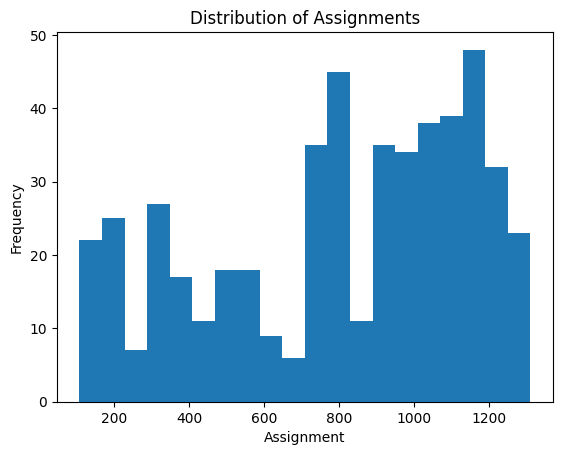

In [225]:
# Flatten all selected assignments
flat_assignments = [item for sublist in selected_assignments for item in sublist]

plt.hist(flat_assignments, bins=20)
plt.title('Distribution of Assignments')
plt.xlabel('Assignment')
plt.ylabel('Frequency')
plt.show()